In [128]:

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [129]:
from src import utils
from src.utils import print_title

In [130]:
import importlib
importlib.reload(utils)

<module 'src.utils' from '/Users/jobandtalent/Documents/GitHub/forecast-incremental-workflow/src/utils.py'>

## DATA INGESTION

### LOAD

In [131]:
day_df_raw = pd.read_csv('../data/day.csv')
display(day_df_raw.head())
print('DF Size: ', day_df_raw.shape)
print('DF Types: \n', day_df_raw.dtypes)

df = day_df_raw.copy()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


DF Size:  (731, 16)
DF Types: 
 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


### DTYPES

In [132]:
datetime_columns = ['dteday']
float64_columns = ['temp','atemp','hum','windspeed']
str_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
int64_columns = ['casual', 'registered', 'cnt']

# Basic data conversion
df = utils.format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)
# Rename columns
df.rename(columns={
    'dteday':'date',
    'yr':'year',
    'mnth':'month',
    'weathersit':'weather',
    'temp':'temperature',
    'atemp':'temperature_sensation',
    'hum':'humidity',
    'casual':'casual_users',
    'registered':'registered_users',
    'cnt':'bikes_rented'
}, inplace=True)
# Drop not used columns
df.drop(columns=['instant'], inplace=True)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
date                     datetime64[ns]
season                           object
year                             object
month                            object
holiday                          object
weekday                          object
workingday                       object
weather                          object
temperature                     float64
temperature_sensation           float64
humidity                        float64
windspeed                       float64
casual_users                      Int64
registered_users                  Int64
bikes_rented                      Int64
dtype: object


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## DATA CLEANING AND QA

### DESCRIBE

In [133]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('DISTRIBUTIONS')
display(df['season'].value_counts().sort_index())
display(df['year'].value_counts().sort_index())
display(df['month'].value_counts().sort_index())
display(df['holiday'].value_counts().sort_index())
display(df['weekday'].value_counts().sort_index())
display(df['workingday'].value_counts().sort_index())
display(df['weather'].value_counts().sort_index())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   731 non-null    datetime64[ns]
 1   season                 731 non-null    object        
 2   year                   731 non-null    object        
 3   month                  731 non-null    object        
 4   holiday                731 non-null    object        
 5   weekday                731 non-null    object        
 6   workingday             731 non-null    object        
 7   weather                731 non-null    object        
 8   temperature            731 non-null    float64       
 9   temperature_sensation  731 non-null    float64       
 10  humidity               731 non-null    float64       
 11  windspeed              731 non-null    float64       
 12  casu

None

----------------------- DF DESCRIBE -----------------------


,date,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented
count,731,731.000000,731.000000,731.000000,731.000000,731.0,731.0,731.0
mean,2012-01-01 00:00:00,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
min,2011-01-01 00:00:00,0.059130,0.079070,0.000000,0.022392,2.0,20.0,22.0
25%,2011-07-02 12:00:00,0.337083,0.337842,0.520000,0.134950,315.5,2497.0,3152.0
50%,2012-01-01 00:00:00,0.498333,0.486733,0.626667,0.180975,713.0,3662.0,4548.0
75%,2012-07-01 12:00:00,0.655417,0.608602,0.730209,0.233214,1096.0,4776.5,5956.0
max,2012-12-31 00:00:00,0.861667,0.840896,0.972500,0.507463,3410.0,6946.0,8714.0
std,NaN,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452


---------------------- DISTRIBUTIONS ----------------------


season
1    181
2    184
3    188
4    178
Name: count, dtype: int64

year
0    365
1    366
Name: count, dtype: int64

month
1     62
10    62
11    60
12    62
2     57
3     62
4     60
5     62
6     60
7     62
8     62
9     60
Name: count, dtype: int64

holiday
0    710
1     21
Name: count, dtype: int64

weekday
0    105
1    105
2    104
3    104
4    104
5    104
6    105
Name: count, dtype: int64

workingday
0    231
1    500
Name: count, dtype: int64

weather
1    463
2    247
3     21
Name: count, dtype: int64

### DUPLICATES

In [134]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [135]:

primary_key_column = 'date'

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = primary_key_column))

    # Keep only the first following timestamp column order
    if primary_key_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated' +  primary_key_column)
    else:
        df = df.sort_values(primary_key_column).drop_duplicates(subset=primary_key_column, keep='first')
        print('Kept the most recent row for each duplicated ' + primary_key_column)

# of duplicated on date column: 0


### NULLS

In [136]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
date                     0
season                   0
year                     0
month                    0
holiday                  0
weekday                  0
workingday               0
weather                  0
temperature              0
temperature_sensation    0
humidity                 0
windspeed                0
casual_users             0
registered_users         0
bikes_rented             0
dtype: int64


### OUTLIERS

In [137]:
target_columns = ['casual_users', 'registered_users', 'bikes_rented']

numeric_cols = df.drop(columns=target_columns, errors='ignore').select_dtypes(include=["number"])
outliers_df = utils.detect_outliers(numeric_cols, method="iqr")
outlier_rows = df.loc[outliers_df.any(axis=1)]
print_title('ANOMALY ROWS')
display(outliers_df[outliers_df['is_outlier']])

df["extreme_weather"] = outliers_df["is_outlier"].astype(int).astype(str)
display(df.head())

----------------------- ANOMALY ROWS -----------------------


,iqr_outlier,zscore_outlier,outlier_columns,is_outlier
44,True,False,[windspeed],True
49,True,False,"[humidity, windspeed]",True
68,True,False,[humidity],True
93,True,False,[windspeed],True
94,True,False,[windspeed],True
292,True,False,[windspeed],True
382,True,False,[windspeed],True
407,True,False,[windspeed],True
420,True,False,[windspeed],True
432,True,False,[windspeed],True


,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,casual_users,registered_users,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,0
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,0
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,0
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,0
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,0


## EDA

#### TIME SERIES FACTORS

In [138]:
target_column = 'bikes_rented'
try:
    df.drop(columns=['registered_users', 'casual_users'], inplace= True)
except:
    pass
display(df.head())

,date,season,year,month,holiday,weekday,workingday,weather,temperature,temperature_sensation,humidity,windspeed,bikes_rented,extreme_weather
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,0
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,0
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,0
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,0
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,0


In [139]:
def plot_time_series(df, time_series, p_alpha = 0.9, p_linestyle = "--"):
    fig, ax = plt.subplots(figsize=(20,6))
    
    colors = plt.get_cmap("tab10")(range(len(time_series)))
    for i, serie in enumerate(time_series):
        alpha = p_alpha if i > 0 else 1
        linestyle = p_linestyle if i > 0 else "-"
        
        ax.plot(df['date'], df[serie], label=serie, linewidth=2, color=colors[i], alpha=alpha, linestyle=linestyle)

    ax.set_title("Bikes rented", fontsize=14, fontweight='bold')

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.tick_params(axis='y', labelsize=10)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(frameon=False, fontsize=12)

    plt.show()

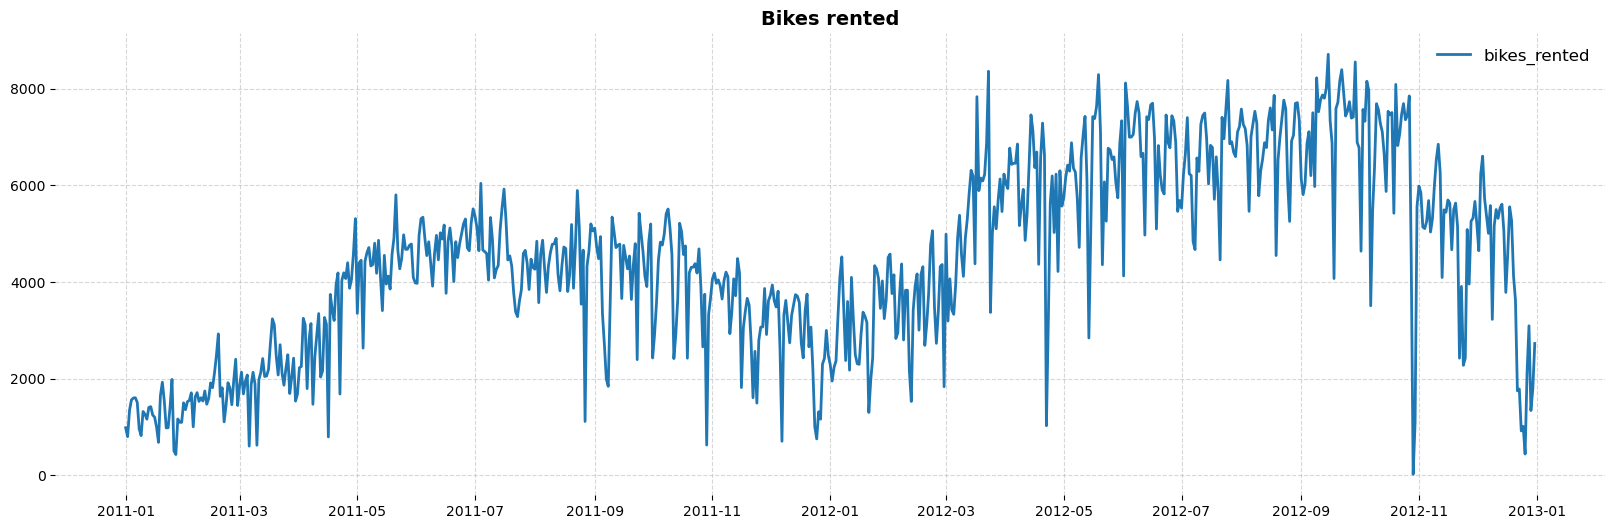

In [140]:
plot_time_series(df, [target_column], 0.9, '--')

In [141]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["bikes_rented"])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")
print("Conclusion:", "Stationary" if result[1] < 0.05 else "Non-stationary")

ADF Statistic: -1.8774481444374296
P-value: 0.34274344033921944
Conclusion: Non-stationary


#### ACF AND PACF

In [157]:
def plot_acf_and_pacf(input_df, additional_text = ''):
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    plot_acf(input_df, ax=axes[0], lags=50)
    plot_pacf(input_df, ax=axes[1], lags=50)

    axes[0].set_title("ACF" + additional_text, fontsize=14, fontweight='bold')
    axes[1].set_title("PACF" + additional_text, fontsize=14, fontweight='bold')

    for ax in axes:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.grid(True, linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()

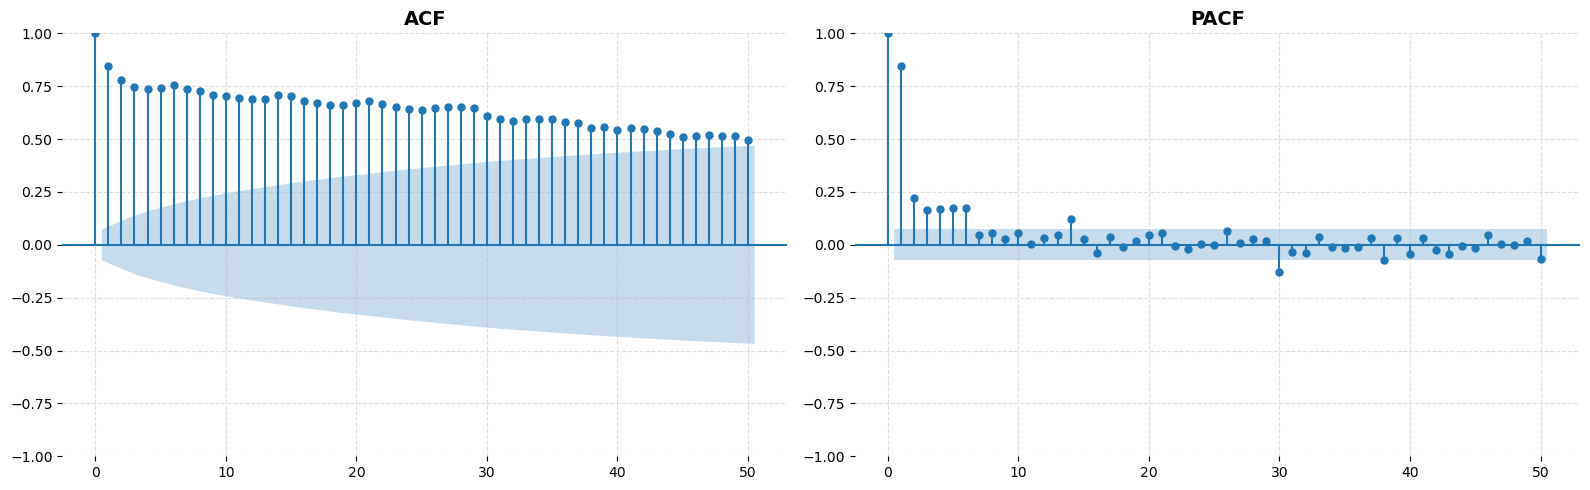

In [158]:
plot_acf_and_pacf(df["bikes_rented"])

#### DECOMPOSITION

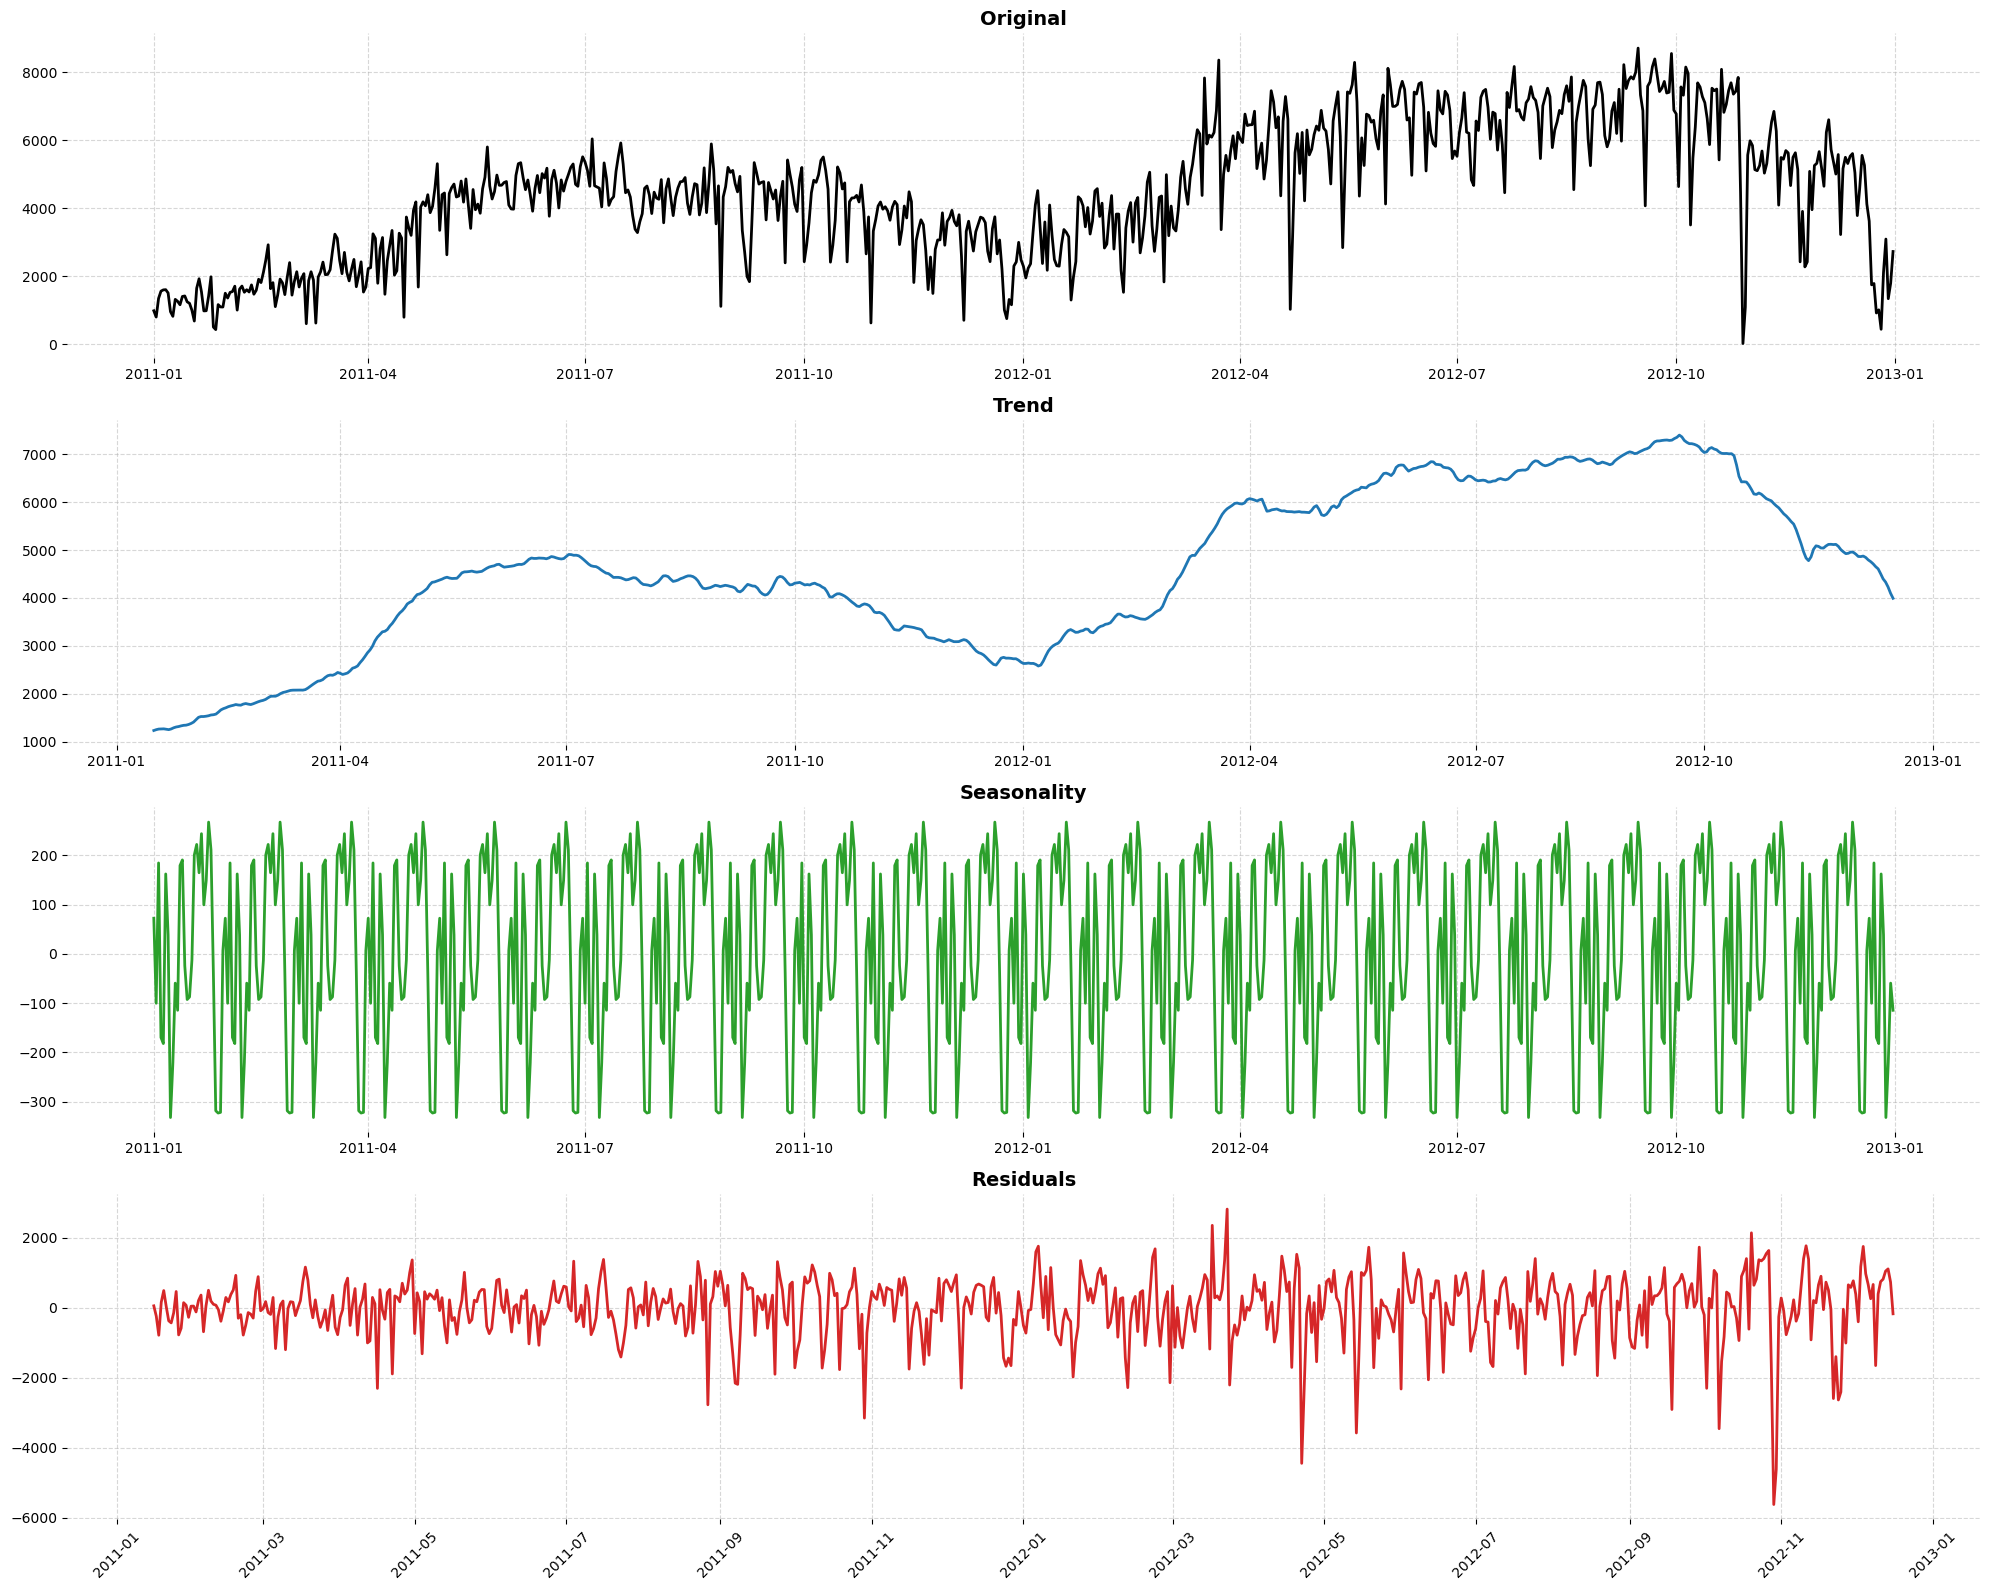

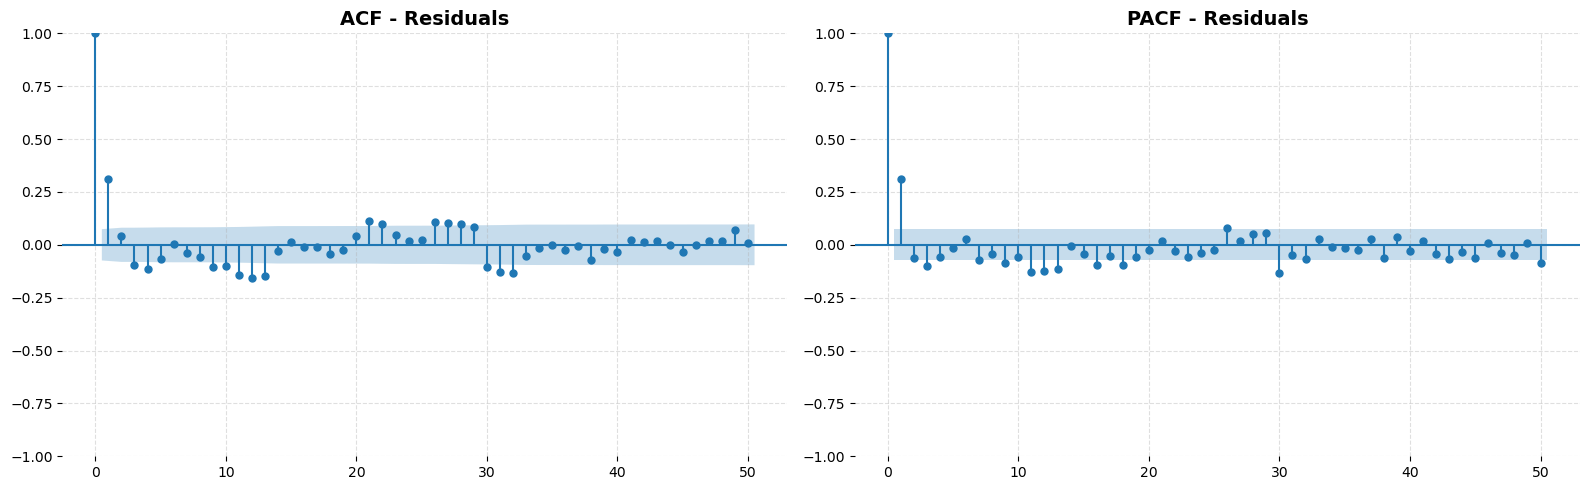

In [159]:
decomposed = seasonal_decompose(df["bikes_rented"], model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(20, 16))

axes[0].plot(df["date"], decomposed.observed, color="black", linewidth=2)
axes[0].set_title("Original", fontsize=14, fontweight='bold')

axes[1].plot(df["date"], decomposed.trend, color="tab:blue", linewidth=2)
axes[1].set_title("Trend", fontsize=14, fontweight='bold')

axes[2].plot(df["date"], decomposed.seasonal, color="tab:green", linewidth=2)
axes[2].set_title("Seasonality", fontsize=14, fontweight='bold')

axes[3].plot(df["date"], decomposed.resid, color="tab:red", linewidth=2)
axes[3].set_title("Residuals", fontsize=14, fontweight='bold')

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.5)

axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[-1].tick_params(axis='x', rotation=45, labelsize=10)

plt.tight_layout()
plt.show()

plot_acf_and_pacf(decomposed.resid.dropna(), ' - Residuals')

#### CORRELATION

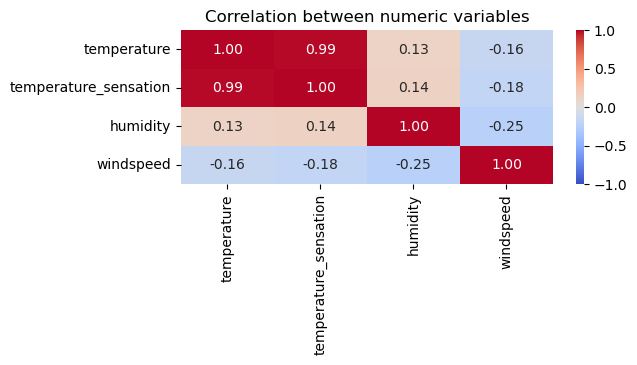

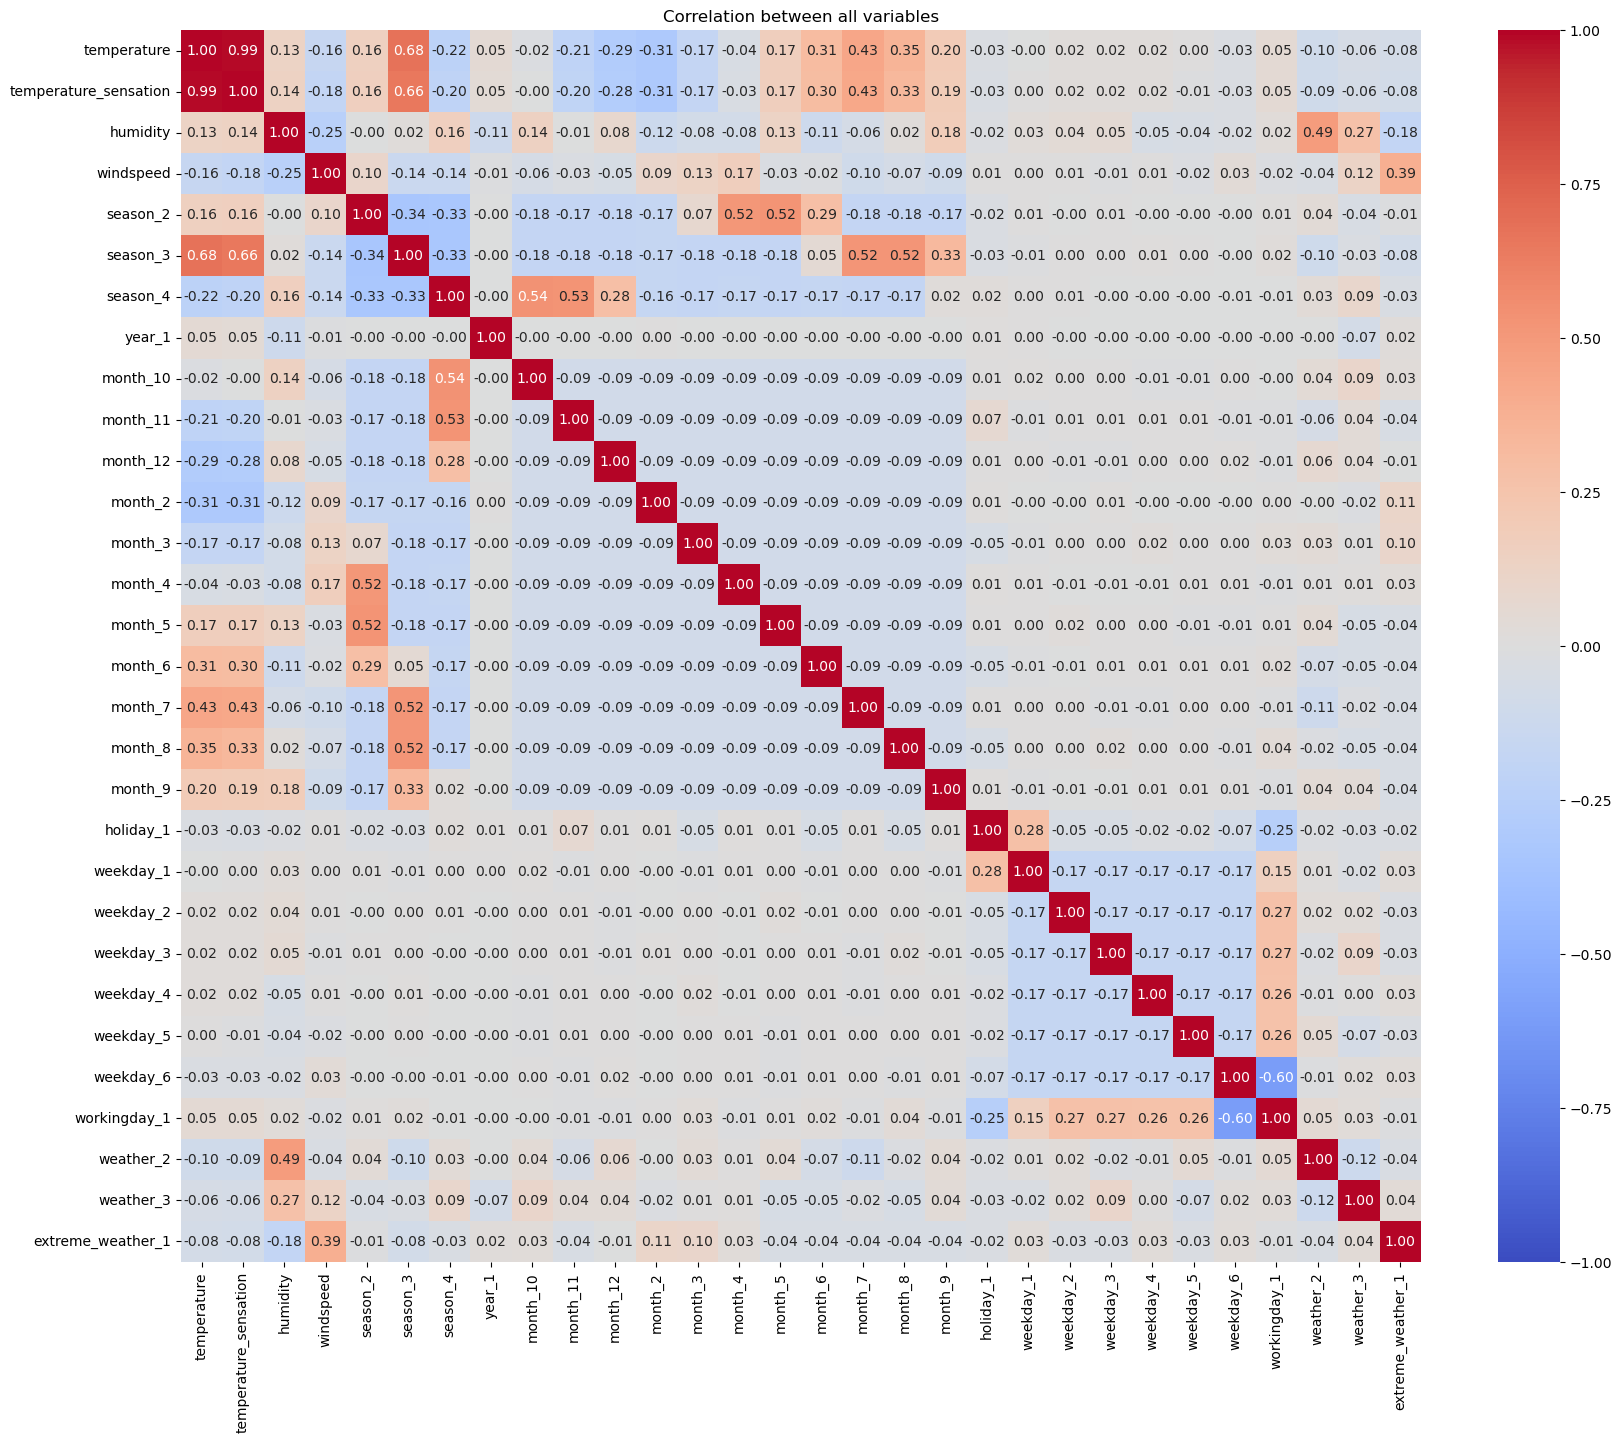

In [160]:
plt.figure(figsize=(6, 2))
df_corr = df.select_dtypes(include=["number"]).drop(columns=["bikes_rented"], errors="ignore").corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between numeric variables")
plt.show()

plt.figure(figsize=(20, 16))
df_encoded = pd.get_dummies(df.drop(columns=["bikes_rented", "date"], errors="ignore"), drop_first=True)
df_corr = df_encoded.corr()
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation between all variables")
plt.show()

## BASE FORECAST FEATURE ENGINEERING